<a href="https://colab.research.google.com/github/shekoelnawawy/Marksman/blob/main/Marksman_Backdoor_Attack_in_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MedMNIST Package Installation**

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D [1][2]. All images are pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with the corresponding classification labels. For more information on the MedMNIST dataset refer to the following link: https://medmnist.com/

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=2818d1e1c90f35ac1e0b92a012a7868d3e3462afb956970617c6918083186092
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


Importing the necesssary libraries

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch.nn.functional as F
import cv2
from scipy.interpolate import make_interp_spline
from google.colab.patches import cv2_imshow
import random
import sys
import copy

Printing the MedMNIST dataset version

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.1 @ https://github.com/MedMNIST/MedMNIST/


# BloodMNIST Dataset

Setting up the parameters for the BloodMNIST dataset in preparation for the download and pre-processing steps.

BloodMNIST dataset is a multi-class dataset that consists of blood cell microscopic images. Images are assigned one of eight labels as follows:

0: Basophil

1: Eosinophil

2: Erythroblast

3: Immature granulocytes(Myelocytes, Metamyelocytes and Promyelocytes)

4: Lymphocyte

5: Monocyte

6: Neutrophil

7: Platelet

The BloodMNIST dataset contains 17,092 samples that are split into:

Train: 11,959

Validation: 1,712

Test: 3,421

In [4]:
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

1.   Read the BloodMNIST data
2.   Preprocess the images by converting them into tensors
3.   Normalize the images 
4.   Split the dataset into train, test and validation subsets
5.   Encapsulate the subsets into dataloader form

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

val_dataset = DataClass(split='val', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 35461855/35461855 [01:03<00:00, 555835.62it/s] 


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


Printing subsets information

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Datas

Plotting the histograms of the class distributions for the training, validation, and testing sets.

In [7]:
firstTime = True
for x, y in train_loader:
  if firstTime:
    train_classes = y
    firstTime = False
  else:
    train_classes = torch.cat((train_classes, y), axis = 0)
train_classes = train_classes.detach().numpy()

firstTime = True
for x, y in test_loader:
  if firstTime:
    test_classes = y
    firstTime = False
  else:
    test_classes = torch.cat((test_classes, y), axis = 0)
test_classes = test_classes.detach().numpy()

firstTime = True
for x, y in val_loader:
  if firstTime:
    val_classes = y
    firstTime = False
  else:
    val_classes = torch.cat((val_classes, y), axis = 0)
val_classes = val_classes.detach().numpy()

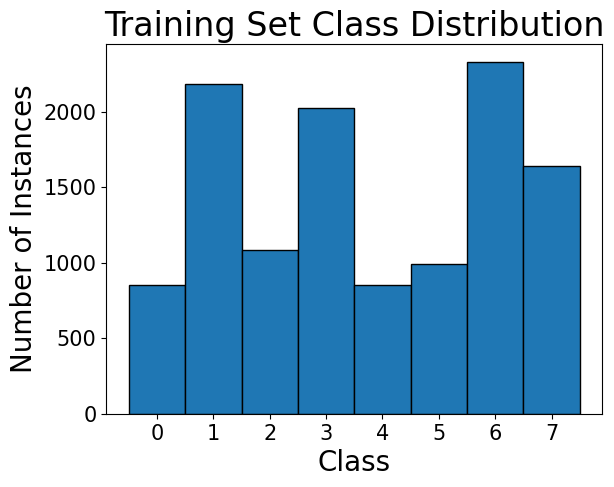

In [8]:
plt.title("Training Set Class Distribution", fontsize = 24)
plt.ylabel("Number of Instances", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(train_classes, bins=np.arange(n_classes+1) - 0.5, edgecolor='black')
plt.show()

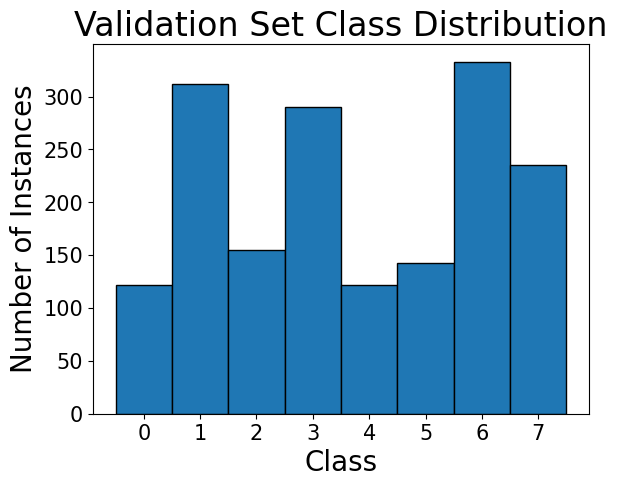

In [9]:
plt.title("Validation Set Class Distribution", fontsize = 24)
plt.ylabel("Number of Instances", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(val_classes, bins=np.arange(n_classes+1) - 0.5, edgecolor='black')
plt.show()

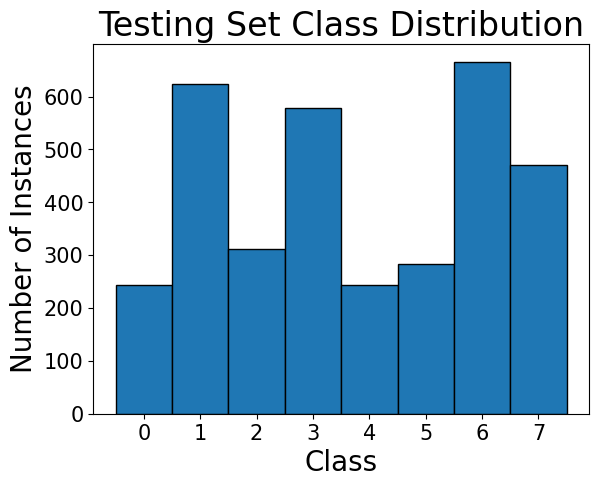

In [10]:
plt.title("Testing Set Class Distribution", fontsize = 24)
plt.ylabel("Number of Instances", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(test_classes, bins=np.arange(n_classes+1) - 0.5, edgecolor='black')
plt.show()

Image visualization

In [11]:
# visualizing one image
train_dataset.montage(length=1)

/usr/local/lib/python3.9/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


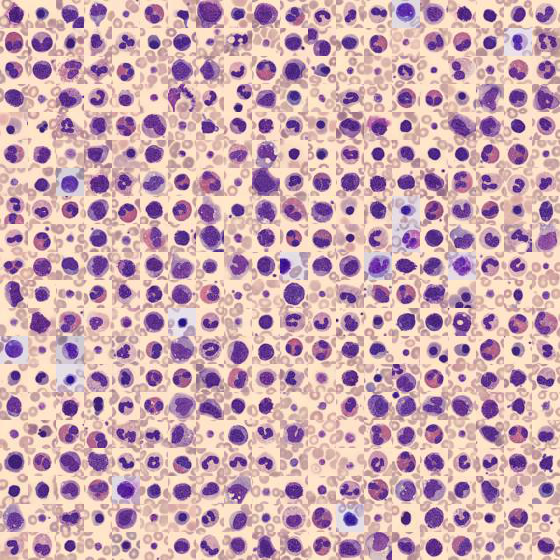

In [12]:
# A montage of 20*20 images
train_dataset.montage(length=20)

# Base Model Design and Initial Testing

Defining a simple CNN Model for classification, loss function and optimizer

In [13]:
# CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# loss function
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Training the base model

In [14]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device parameter
print("Device parameter:", device)

loss_fn = nn.CrossEntropyLoss()

Device parameter: cuda


In [15]:
# train
model = model.to(device)
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs.to(device), targets.to(device))
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs.to(device), targets.to(device))
        
        loss.backward()
        optimizer.step()

100%|██████████| 94/94 [00:03<00:00, 28.20it/s]


Testing the base model on the training validation set and on the testing set

In [16]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true.to(device), targets.to(device)), 0)
            y_score = torch.cat((y_score.to(device), outputs.to(device)), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.999  acc:0.954
test  auc: 0.994  acc:0.917


The results show that the model performs relatively well on both sets, an indication that the model generalizes well to previously unseen data.

Checking the shape of the input and output tensors

In [17]:
for x, y in train_loader:
    print('Input tensor shape:')
    print(x.shape)
    print()
    print('Output tensor shape:')
    print(y.shape)
    break

Input tensor shape:
torch.Size([128, 3, 28, 28])

Output tensor shape:
torch.Size([128, 1])


Defining a function to visualize a tensor-based image

In [18]:
def tensor_imshow(t):
  plt.imshow(t.permute(1, 2, 0))

Evaluating the model on a single test instance. The blood cell is displayed below along with the actual and predicted class labels. The model correctly predicts the test sample as class 3: Immature granulocytes(Myelocytes, Metamyelocytes and Promyelocytes).

In [19]:
data_loader = test_loader
inputs, classes = next(iter(data_loader))

Actual class:
tensor([3])

Predicted class:
3


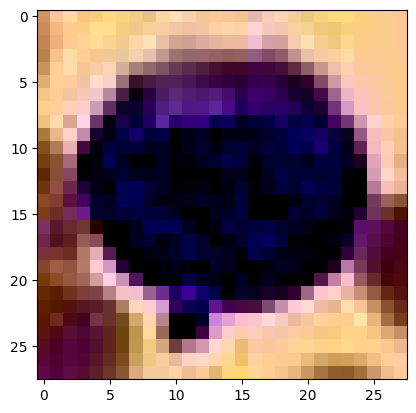

In [20]:
model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
sample = 0
with torch.no_grad():
    test = inputs[sample].reshape([1,3,28, 28])
    outputs = model(test.to(device))
    outputs = outputs.softmax(dim=-1)
    tensor_imshow(inputs[sample])
    outputs = outputs.cpu().detach().numpy()
    print('Actual class:')
    print(classes[sample])
    print()
    print('Predicted class:')
    print(np.argmax(outputs))

Defining a function to calculate the accuracy on the test set for reusability later in the code

In [21]:
def calculate_accuracy(model):
  model = model.to(device)
  model.eval()
  y_true = torch.tensor([])
  y_predict = torch.tensor([])

  data_loader = test_loader

  with torch.no_grad():
      for inputs, targets in data_loader:
          outputs = model(inputs.to(device))

          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              outputs = outputs.softmax(dim=-1)
          else:
              targets = targets.squeeze().long()
              outputs = outputs.softmax(dim=-1)
              targets = targets.float().resize_(len(targets), 1)


          y_true = torch.cat((y_true.to(device), targets.to(device)), 0)
          y_predict = torch.cat((y_predict.to(device), torch.argmax(outputs.to(device), dim=1)), 0)

      y_true = y_true.reshape(3421)
      y_true = y_true.cpu().numpy()
      y_predict = y_predict.cpu().detach().numpy()

      return (np.count_nonzero(y_true == y_predict)/len(y_predict))*100

Calculating the clean test set accuracy before mounting any attack.

In [22]:
cleanAccuracyBefore = calculate_accuracy(model)
print("Clean Data Accuracy Before Attack = " + str(cleanAccuracyBefore))

Clean Data Accuracy Before Attack = 91.69833382052032


# Marksman Backdoor Attack

Defining the trigger function used to generate Marksman backdoor triggers (Trigger function is implemented as an autoencoder as shown in [3])

In [23]:
class ConditionalAutoencoder(nn.Module):
    def __init__(self, n_classes, input_dim):
        super().__init__()
        
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.linear_c = nn.Linear(n_classes, 1 * input_dim * input_dim)
        self.n_classes = n_classes
        self.input_dim = input_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3+1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x, c):
        c = self.linear_c(self.label_emb(c)).view(-1, 1, self.input_dim, self.input_dim)
        x = torch.cat([x, c], dim=1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
atkmodel = ConditionalAutoencoder(n_classes, 28).to(device)
# Copy of attack model
tgtmodel = ConditionalAutoencoder(n_classes, 28).to(device)

In [25]:
# Optimizer
tgtoptimizer = optim.SGD(tgtmodel.parameters(), lr=lr)
marksman_model = copy.deepcopy(model.to(device))
marksman_optimizer = optim.SGD(marksman_model.parameters(), lr=lr, momentum=0.9)

Defining a function to sample attack labels that are different from the actual label

In [26]:
def sample_negative_labels(label, n_classes):
    label_cpu = label.detach().cpu().numpy()
    neg_label = [np.random.choice([e for e in range(n_classes) if e != l], 1)[0] for l in label_cpu]
    neg_label = torch.tensor(np.array(neg_label))
    return neg_label

Simultaneously learn the poisoned classifier and the trigger function

In [27]:
eps=0.2
alpha = 0.8
beta = 1.0
attack_portion = 0.1
train_epoch = 20

for epoch in range (train_epoch):
  atkmodel.eval()
  marksman_model.train()
  tgtmodel.train()

  losslist = []
  pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

  for batch_idx, (data, target) in pbar:
      bs = data.size(0)
      
      ########################################
      #### Update Trigger Function ####
      ########################################
      data, target = data.to(device), target.to(device)
      atktarget = sample_negative_labels(target, n_classes).to(device) #randomly sample any labels
      
      noise = tgtmodel(data, atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)

      
      atkdata = data+noise
      aug_atkdata = atkdata
      aug_data = data
              
      if attack_portion < 1.0:
          aug_atkdata = aug_atkdata[:int(attack_portion*bs)]
          atktarget = atktarget[:int(attack_portion*bs)]

      # Calculate loss
      atkoutput = marksman_model(aug_atkdata)
      loss_poison = loss_fn(atkoutput, atktarget)
      loss1 = loss_poison
      losslist.append(loss_poison.item())
      
      marksman_optimizer.zero_grad()
      tgtoptimizer.zero_grad()
      loss1.backward()
      tgtoptimizer.step() #this is the slowest step

      ###############################
      #### Update the classifier ####
      ###############################
      atktarget = sample_negative_labels(target, n_classes).to(device) #randomly sample any labels
      
      noise = atkmodel(data, atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)
      atkdata = data+noise
      aug_atkdata = atkdata
      
      if attack_portion < 1.0:
          aug_atkdata = aug_atkdata[:int(attack_portion*bs)]
          atktarget = atktarget[:int(attack_portion*bs)]
      
      output = marksman_model(aug_data)
      atkoutput = marksman_model(aug_atkdata)
      loss_clean = loss_fn(output, target.reshape([len(target)]))
      loss_poison = loss_fn(atkoutput, atktarget)
      loss2 = loss_clean * alpha + (1-alpha) * loss_poison
      marksman_optimizer.zero_grad()
      loss2.backward()
      marksman_optimizer.step()
      
                    
      if batch_idx % 10 == 0 or batch_idx == (len(train_loader)-1):
          pbar.set_description('Train [{}] Loss: clean {:.4f} poison {:.4f} CLS {:.4f} ATK:{:.4f}'.format(
              epoch, loss_clean.item(), loss_poison.item(), loss1.item(), loss2.item()))
  pbar.close()


Train [0] Loss: clean 0.5101 poison 2.7561 CLS 1.8112 ATK:0.9593: 100%|██████████| 94/94 [00:06<00:00, 14.36it/s]
Train [1] Loss: clean 0.5445 poison 3.6400 CLS 1.4166 ATK:1.1636: 100%|██████████| 94/94 [00:05<00:00, 16.99it/s]
Train [2] Loss: clean 0.4716 poison 3.0958 CLS 1.2346 ATK:0.9964: 100%|██████████| 94/94 [00:06<00:00, 14.76it/s]
Train [3] Loss: clean 0.5092 poison 3.4475 CLS 1.2050 ATK:1.0968: 100%|██████████| 94/94 [00:05<00:00, 16.84it/s]
Train [4] Loss: clean 0.5211 poison 2.5461 CLS 1.2558 ATK:0.9261: 100%|██████████| 94/94 [00:06<00:00, 15.42it/s]
Train [5] Loss: clean 0.3844 poison 2.7305 CLS 1.7305 ATK:0.8536: 100%|██████████| 94/94 [00:05<00:00, 16.39it/s]
Train [6] Loss: clean 0.3104 poison 3.6060 CLS 1.0410 ATK:0.9695: 100%|██████████| 94/94 [00:05<00:00, 16.21it/s]
Train [7] Loss: clean 0.4086 poison 3.4019 CLS 1.1506 ATK:1.0072: 100%|██████████| 94/94 [00:06<00:00, 15.17it/s]
Train [8] Loss: clean 0.3678 poison 2.5237 CLS 0.8949 ATK:0.7990: 100%|██████████| 94/94

Testing the trigger function and the poisoned model on the same test instance that was shown in the clean testing above for demonstration purposes. The attack target is chosen to be class 2: Erythroblast

In [28]:

atktarget = torch.tensor([2]).to(device)  # select target class as class 2
tgtmodel.eval()
x = inputs[sample].reshape([1,3,28,28])
noise = tgtmodel(x.to(device), atktarget) * eps # generate noise to be added to the test sample
m = nn.Upsample(size=(28,28))
noise = m(noise)
atkdata = inputs[sample].to(device) + noise.to(device) # generate poisoned sample

Display the generated noise pattern (trigger)

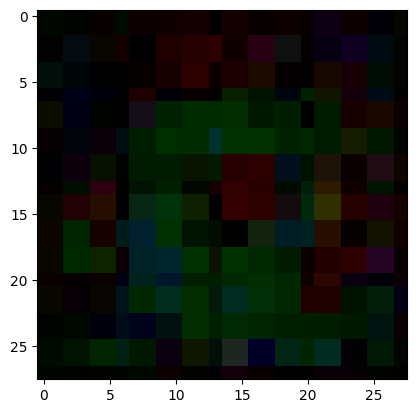

In [29]:
noise = noise.reshape([3,28,28])
noise = noise.cpu().detach().numpy()
noise = torch.tensor(noise)
tensor_imshow(noise)

Actual Class:
tensor([3])

Predicted Class:
2


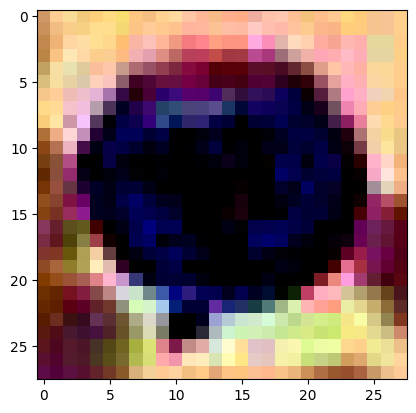

In [30]:
marksman_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    outputs = marksman_model(atkdata)
    outputs = outputs.softmax(dim=-1)

    xatkdata = atkdata.reshape([3,28,28])
    xatkdata = xatkdata.cpu().detach().numpy()
    xatkdata = torch.tensor(xatkdata)
    tensor_imshow(xatkdata)

    outputs = outputs.cpu().detach().numpy()
    print('Actual Class:')
    print(classes[sample])
    print()
    print('Predicted Class:')
    print(np.argmax(outputs))

As shown above, the trigger function successfully generates a poisoned sample that is able to deceive the poisoned model into misclassifying it as class 2: Erythroblast, even though it was able to correctly classify it earlier before mounting the attack.

Calculating the attack success rate

In [31]:
target_class = 2
marksman_model.eval()
tgtmodel.eval()

pbar = tqdm(enumerate(test_loader), total=len(test_loader), position=0, leave=True)
y_true = torch.tensor([])
y_score = torch.tensor([])
predicted_classes = []
with torch.no_grad():
  for batch_idx, (data, targets) in pbar:
      data, targets = data.to(device), targets.to(device)
      atktarget = torch.full((1, len(data)), 2).to(device)

      noise = tgtmodel(data.to(device), atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)
      atkdata = data.to(device) + noise.to(device)

      outputs = marksman_model(atkdata)

      if task == 'multi-label, binary-class':
          targets = targets.to(torch.float32)
          outputs = outputs.softmax(dim=-1)
      else:
          targets = targets.squeeze().long()
          outputs = outputs.softmax(dim=-1)
          targets = targets.float().resize_(len(targets), 1)

      y_true = torch.cat((y_true.to(device), targets.to(device)), 0)
      y_score = torch.cat((y_score.to(device), outputs.to(device)), 0)
      
      for i in range(len(outputs)):
        predicted_classes.append(int(np.argmax(outputs[i].cpu())))
  y_true = y_true.cpu().numpy()
  y_score = y_score.cpu().detach().numpy()
  
  evaluator = Evaluator(data_flag, 'test')
  metrics = evaluator.evaluate(y_score)


predicted_classes = np.array(predicted_classes)
indices = np.asarray(y_true!=target_class).nonzero()
print()
print("Number of test instances predicted as class " + str(target_class) +": " + str(len(np.where(predicted_classes[indices[0]] == target_class)[0])))
print("Total number of test instances: " + str(len(predicted_classes[indices[0]])))
ASR = (len(np.where(predicted_classes[indices[0]] == target_class)[0])/len(predicted_classes[indices[0]]))*100
print("ASR = " + str(round(ASR,3)))

100%|██████████| 14/14 [00:01<00:00, 11.31it/s]


Number of test instances predicted as class 2: 2737
Total number of test instances: 3110
ASR = 88.006


Calculating the performance on clean test set after mounting the attack. As can be seen from the results, even though we we were able to attain a very high attack success rate (ASR) as shown above, while maintaining a relatively good performance on clean test set (i.e., not much clean data performance is lost due to the Marksman backdoor attack).



In [32]:
cleanAccuracyAfter = calculate_accuracy(marksman_model)
print("Clean Data Accuracy After Attack = " + str(cleanAccuracyAfter))

Clean Data Accuracy After Attack = 88.68751826951183


In [33]:
print("Summary of the results:")
print("Poisoning Rate = " + str(attack_portion*100))
print("Epsilon = " + str(eps))
print("Clean Data Accuracy Before Attack = " + str(round(cleanAccuracyBefore, 3)))
print("Clean Data Accuracy After Attack = " + str(round(cleanAccuracyAfter,3)))
print("Attack Success Rate = " + str(round(ASR,3)))

Summary of the results:
Poisoning Rate = 10.0
Epsilon = 0.2
Clean Data Accuracy Before Attack = 91.698
Clean Data Accuracy After Attack = 88.688
Attack Success Rate = 88.006


Plotting Attack Success Rate Against Varying Epsilon (Amount of Perturbation)

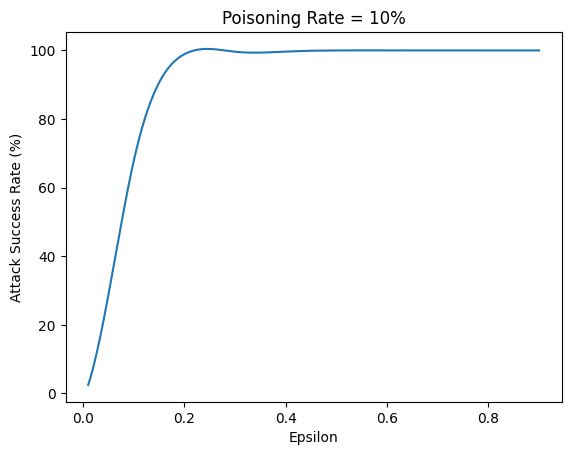

In [34]:
x = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y=np.array([2.486, 28.817, 67.867, 98.916, 99.617, 99.668, 100, 100, 100, 100, 100])
X_Y_Spline = make_interp_spline(x, y)

X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_, Y_)
plt.title("Poisoning Rate = 10%")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate (%)")
plt.show()

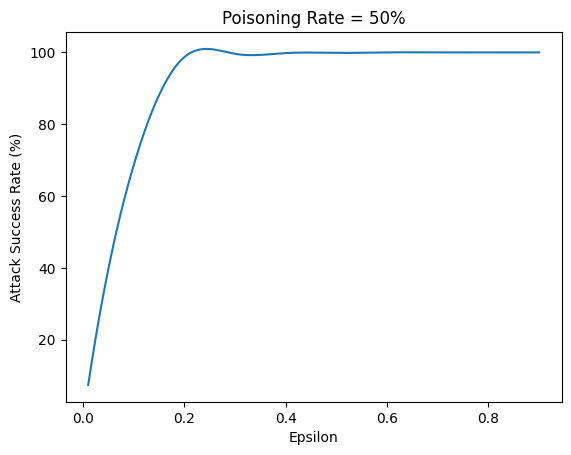

In [35]:
x = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y=np.array([7.418, 39.857, 68.681, 98.714, 99.588, 99.808, 99.865, 100, 100, 100, 100])
X_Y_Spline = make_interp_spline(x, y)

X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_, Y_)
plt.title("Poisoning Rate = 50%")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate (%)")
plt.show()

# STRIP Defense Technique

Defining a function to convert from tensor to numpy array

In [36]:
def tensor_to_numpy(img):
  out = img.permute(1, 2, 0).cpu().detach().numpy()
  out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
  out = out*255
  return out

Defining a function to convert from numpy array to tensor

In [37]:
def numpy_to_tensor(img):
  out = img/255
  out = np.float32(out)
  out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
  out = torch.from_numpy(out).permute(2, 0, 1)
  return out

Defining a helper function to superimpose two images, this will be useful to test the STRIP defense mechanism. Recall from [3], that STRIP is "a representative inference-phase detection method, which perturbs the input image and calculates the entropy of the predictions of these perturbed images. STRIP determines if an image is a backdoor input by relying on the fact that the entropy of the perturbed backdoor input tends to be lower than that of the clean one."

Therefore, we intend to use the superimpose function to perturb the clean inputs as per [4] to generate backdoored inputs. After that, we would like to check if STRIP is successful in detecting backdoored images by observing the differences between the benign entropy and the entropy of the perturbed inputs.

In [38]:
def superimpose(background, overlay): 
  sample = cv2.addWeighted(background,0.5,overlay,0.5,0)
  return (sample.reshape(28,28,3))

Defining a function to calculate the benign entropy

In [39]:
def benign_entropyCal(model):
  model = model.to(device)
  model.eval()
  y_true = torch.tensor([])
  y_predict = torch.tensor([])
  overlay_inputs, overlay_classes = next(iter(train_loader))
  N = 20
  data_loader = test_loader
  entropy_benign = [0] * 14 * 20
  j = 0
  firstInput = True

  with torch.no_grad():
      for background_inputs, background_targets in test_loader:
        for i in range(20):
          for n in range(N):
            index = random.randint(0, len(overlay_inputs)-1)
            img2 = overlay_inputs[index]
            superimposed_image = superimpose(tensor_to_numpy(background_inputs[i]), tensor_to_numpy(img2))
            superimposed_image = torch.reshape(numpy_to_tensor(superimposed_image), (1,3,28,28))
            if firstInput:
              attkimages = superimposed_image
              firstInput = False
            else:
              attkimages = torch.cat((attkimages, superimposed_image), 0)


          outputs = model(attkimages.to(device))

          if task == 'multi-label, binary-class':
              background_targets = background_targets.to(torch.float32)
              outputs = outputs.softmax(dim=-1)
          else:
              background_targets = background_targets.squeeze().long()
              outputs = outputs.softmax(dim=-1)
              background_targets = background_targets.float().resize_(len(targets), 1)


          y_predict = torch.cat((y_predict.to(device), torch.argmax(outputs.to(device), dim=1)), 0)
          py1_add = y_predict.cpu().detach().numpy()
          EntropySum = -np.nansum(py1_add*np.log2(py1_add))
          entropy_benign[j] = EntropySum
          j = j + 1

      return entropy_benign

In [40]:
entropy_benign = benign_entropyCal(marksman_model)

<ipython-input-39-d96514e21d58>:41: RuntimeWarning: divide by zero encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
<ipython-input-39-d96514e21d58>:41: RuntimeWarning: invalid value encountered in multiply
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


Defining a function to calculate the backdoor entropy

In [41]:
def backdoor_entropyCal(model, tgtmodel):
  model = model.to(device)
  tgtmodel = tgtmodel.to(device)
  model.eval()
  tgtmodel.eval()
  y_true = torch.tensor([])
  y_predict = torch.tensor([])
  overlay_inputs, overlay_classes = next(iter(train_loader))
  N = 20
  data_loader = test_loader
  entropy_backdoor = [0] * 14 * 20
  j = 0
  firstInput = True
  eps = 0.2

  with torch.no_grad():
      for background_inputs, background_targets in test_loader:
        for i in range(20):

          atktarget = torch.tensor([random.randint(0,7)]).to(device)
          x = background_inputs[i].reshape([1,3,28,28])
          noise = tgtmodel(x.to(device), atktarget) * eps
          m = nn.Upsample(size=(28,28))
          noise = m(noise)
          atkdata = background_inputs[i].to(device) + noise.to(device)
          atkdata = atkdata.reshape([3,28,28])

          for n in range(N):
            index = random.randint(0, len(overlay_inputs)-1)
            img2 = overlay_inputs[index]
            superimposed_image = superimpose(tensor_to_numpy(atkdata), tensor_to_numpy(img2))
            superimposed_image = torch.reshape(numpy_to_tensor(superimposed_image), (1,3,28,28))
            if firstInput:
              attkimages = superimposed_image
              firstInput = False
            else:
              attkimages = torch.cat((attkimages, superimposed_image), 0)


          outputs = model(attkimages.to(device))

          if task == 'multi-label, binary-class':
              background_targets = background_targets.to(torch.float32)
              outputs = outputs.softmax(dim=-1)
          else:
              background_targets = background_targets.squeeze().long()
              outputs = outputs.softmax(dim=-1)
              background_targets = background_targets.float().resize_(len(targets), 1)


          y_predict = torch.cat((y_predict.to(device), torch.argmax(outputs.to(device), dim=1)), 0)
          py1_add = y_predict.cpu().detach().numpy()
          EntropySum = -np.nansum(py1_add*np.log2(py1_add))
          entropy_backdoor[j] = EntropySum
          j = j + 1

      return entropy_backdoor

In [42]:
entropy_backdoor = backdoor_entropyCal(marksman_model, tgtmodel)

<ipython-input-41-1b0ee3833a77>:53: RuntimeWarning: divide by zero encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
<ipython-input-41-1b0ee3833a77>:53: RuntimeWarning: invalid value encountered in multiply
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


Plotting the benign and backdoor entropies. Notice from the figure that both the benign and the backdoor entropies have a similar distributions which renders STRIP incapable of detecting backdoor inputs. Therefore, as expected STRIP fails against such a multi-trigger and multi-payload attack.

In [43]:
entropy_benign = [x / 20 for x in entropy_benign] 
entropy_backdoor = [x / 20 for x in entropy_backdoor] 

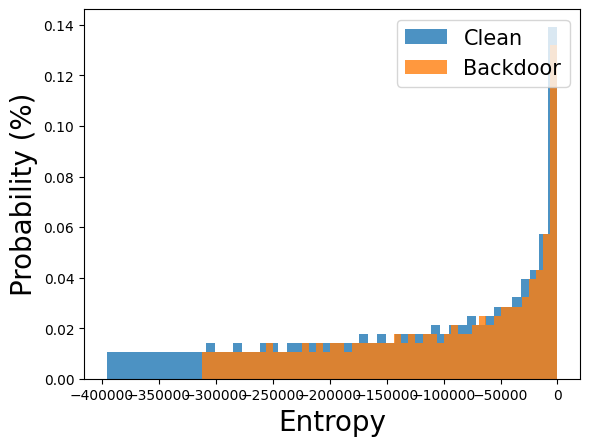

In [44]:
bins = 50
plt.hist(entropy_benign, bins, weights=np.ones(len(entropy_benign)) / len(entropy_benign), alpha=0.8, label='Clean')
plt.hist(entropy_backdoor, bins, weights=np.ones(len(entropy_backdoor)) / len(entropy_backdoor), alpha=0.8, label='Backdoor')
plt.legend(loc='upper right', fontsize = 15)
plt.ylabel('Probability (%)', fontsize = 20)
plt.xlabel('Entropy', fontsize = 20)
plt.tick_params(labelsize=10)

fig1 = plt.gcf()
plt.show()

To visualize the working of the superimpose function above, we present an example of a background image, overlay image, and resulting superimposed image below. The superimposed image was a result of using the superimpose function to generate a perturbed inputed for use with the STRIP defense technique.

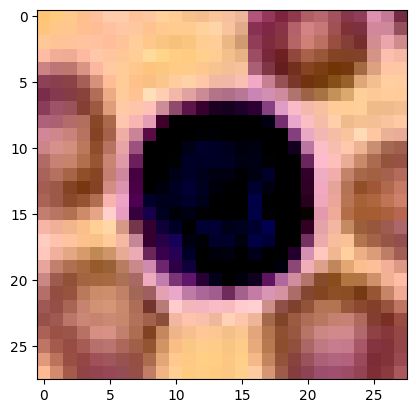

In [ ]:
# background
tensor_imshow(inputs[15])

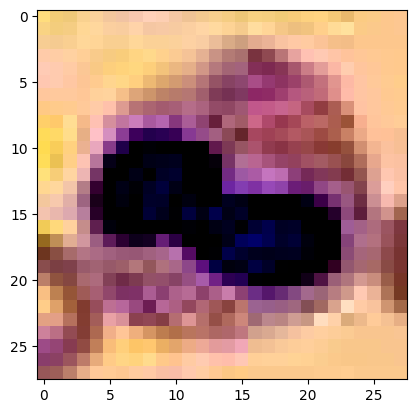

In [ ]:
# overlay
tensor_imshow(inputs[13])

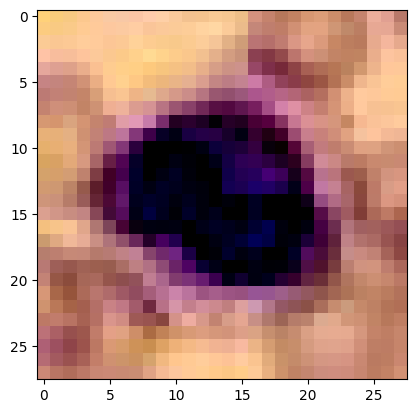

In [ ]:
# superimposed image shows the background and the overlay image superimposed on top of one another
tensor_imshow(numpy_to_tensor(superimpose(tensor_to_numpy(inputs[15]), tensor_to_numpy(inputs[13]))))

# PatchMT Backdoor Attack

Defining the PatchMT trigger function. This is a simple function that generates a black patch at the bottom right corner of an image to serve as the trigger. When added to the original clean image, the trigger can help in evading the detection by the classification model. The PatchMT_trigger function generates eight different triggers that correspond to the target class.

In [ ]:
def PatchMT_trigger(target):
  
  pattern = np.zeros((28,28, 3)).astype(np.float32)

  if target == 0:
    # pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 1:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    # pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 2:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    # pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 3:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    # pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 4:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    # pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 5:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    # pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 6:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    # pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;

  elif target == 7:
    pattern[25][25][0] = -255;  pattern[25][25][1] = -255;  pattern[25][25][2] = -255;
    pattern[25][26][0] = -255;  pattern[25][26][1] = -255;  pattern[25][26][2] = -255;
    pattern[25][27][0] = -255;  pattern[25][27][1] = -255;  pattern[25][27][2] = -255;

    pattern[26][25][0] = -255;  pattern[26][25][1] = -255;  pattern[26][25][2] = -255;
    pattern[26][26][0] = -255;  pattern[26][26][1] = -255;  pattern[26][26][2] = -255;
    pattern[26][27][0] = -255;  pattern[26][27][1] = -255;  pattern[26][27][2] = -255;

    pattern[27][25][0] = -255;  pattern[27][25][1] = -255;  pattern[27][25][2] = -255;
    # pattern[27][26][0] = -255;  pattern[27][26][1] = -255;  pattern[27][26][2] = -255;
    pattern[27][27][0] = -255;  pattern[27][27][1] = -255;  pattern[27][27][2] = -255;    

  return pattern

Defining PatchMT_poison function that adds the generated trigger to the clean image in order to generate the poisoned image.

In [ ]:
def PatchMT_poison(img, target):
  trigger = PatchMT_trigger(target)
  y = cv2.add(tensor_to_numpy(img), trigger)
  return numpy_to_tensor(y)

In [ ]:
# data_loader = test_loader
# inputs, classes = next(iter(train_loader))

Visualizing a clean image before adding the PatchMT trigger

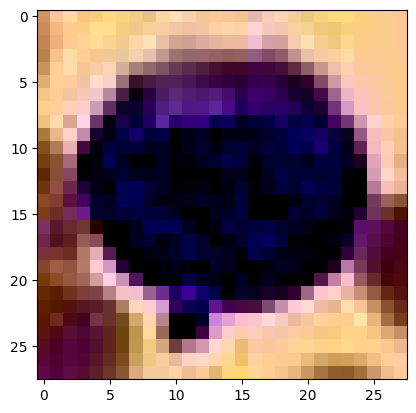

In [ ]:
tensor_imshow(inputs[0])

Poisoning the clean image by adding a trigger that corresponds to class 2: Erythroblast. The trigger can be seen at the bottom right corner of the image.

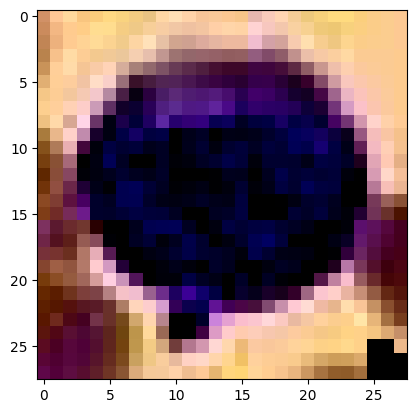

In [ ]:
atkimage = PatchMT_poison(inputs[0], 2)
tensor_imshow(atkimage)

Training the poisoned classifier using the PatchMT trigger function

In [ ]:
patchmt_model = copy.deepcopy(model.to(device))
patchmt_optimizer = optim.SGD(patchmt_model.parameters(), lr=lr, momentum=0.9)

In [ ]:
alpha = 0.8
beta = 1.0
attack_portion = 0.1
train_epoch = 20

for epoch in range (train_epoch):
  patchmt_model.train()

  losslist = []
  pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

  for batch_idx, (data, target) in pbar:
      bs = data.size(0)
      firstInput = True
      ###############################
      #### Update the classifier ####
      ###############################

      data, target = data.to(device), target.to(device)
      atktarget = sample_negative_labels(target, n_classes).to(device) #randomly sample any labels

      
      for i in range(len(data)):
        atkimage = PatchMT_poison(data[i],atktarget[i])
        atkimage = atkimage.reshape([1,3,28,28])

        if firstInput:
          atkdata = atkimage
          firstInput = False
        else:
          atkdata = torch.cat((atkdata, atkimage), 0)
      
      aug_atkdata = atkdata.to(device)

      aug_data = data

      if attack_portion < 1.0:
          aug_atkdata = aug_atkdata[:int(attack_portion*bs)]
          atktarget = atktarget[:int(attack_portion*bs)]
      
      output = patchmt_model(aug_data)
      atkoutput = patchmt_model(aug_atkdata)
      loss_clean = loss_fn(output, target.reshape([len(target)]))
      loss_poison = loss_fn(atkoutput, atktarget)
      loss2 = loss_clean * alpha + (1-alpha) * loss_poison
      patchmt_optimizer.zero_grad()
      loss2.backward()
      patchmt_optimizer.step()
      
                    
      if batch_idx % 10 == 0 or batch_idx == (len(train_loader)-1):
          pbar.set_description('Train [{}] Loss: clean {:.4f} poison {:.4f} CLS {:.4f} ATK:{:.4f}'.format(
              epoch, loss_clean.item(), loss_poison.item(), loss1.item(), loss2.item()))
  pbar.close()


Train [0] Loss: clean 0.6050 poison 3.5296 CLS 1.1533 ATK:1.1899: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s]
Train [1] Loss: clean 0.5155 poison 3.1524 CLS 1.1533 ATK:1.0429: 100%|██████████| 94/94 [00:09<00:00,  9.75it/s]
Train [2] Loss: clean 0.4528 poison 3.5995 CLS 1.1533 ATK:1.0821: 100%|██████████| 94/94 [00:09<00:00,  9.77it/s]
Train [3] Loss: clean 0.3508 poison 3.7750 CLS 1.1533 ATK:1.0357: 100%|██████████| 94/94 [00:09<00:00, 10.40it/s]
Train [4] Loss: clean 0.3170 poison 2.3250 CLS 1.1533 ATK:0.7186: 100%|██████████| 94/94 [00:09<00:00,  9.57it/s]
Train [5] Loss: clean 0.1549 poison 2.3759 CLS 1.1533 ATK:0.5991: 100%|██████████| 94/94 [00:09<00:00,  9.53it/s]
Train [6] Loss: clean 0.1552 poison 2.1703 CLS 1.1533 ATK:0.5582: 100%|██████████| 94/94 [00:09<00:00,  9.51it/s]
Train [7] Loss: clean 0.1455 poison 1.3434 CLS 1.1533 ATK:0.3851: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s]
Train [8] Loss: clean 0.2014 poison 1.4228 CLS 1.1533 ATK:0.4457: 100%|██████████| 94/94

Testing the poisoned PatchMT model and reporting the attack success rate

In [ ]:
target_class = 2
patchmt_model.eval()

pbar = tqdm(enumerate(test_loader), total=len(test_loader), position=0, leave=True)
y_true = torch.tensor([])
predicted_classes = []

atkimage = PatchMT_poison(inputs[0],target_class)
x = inputs[0]
with torch.no_grad():
  for batch_idx, (data, targets) in pbar:
      data, targets = data.to(device), targets.to(device)

      for i in range(len(data)):
        x = data[i]
        atkimage = PatchMT_poison(data[i],target_class)
        atkimage = atkimage.reshape([1,3,28,28])

        if firstInput:
          atkdata = atkimage
          firstInput = False
        else:
          atkdata = torch.cat((atkdata, atkimage), 0)


      outputs = patchmt_model(atkdata.to(device))

      if task == 'multi-label, binary-class':
          targets = targets.to(torch.float32)
          outputs = outputs.softmax(dim=-1)
      else:
          targets = targets.squeeze().long()
          outputs = outputs.softmax(dim=-1)
          targets = targets.float().resize_(len(targets), 1)

      y_true = torch.cat((y_true.to(device), targets.to(device)), 0)
      
      for i in range(len(outputs)):
        predicted_classes.append(int(np.argmax(outputs[i].cpu())))
  y_true = y_true.cpu().numpy()

predicted_classes = np.array(predicted_classes)
indices = np.asarray(y_true!=target_class).nonzero()

print("Number of test instances predicted as target class: " + str(len(np.where(predicted_classes[indices[0]] == target_class)[0])))
print("Total number of test instances: " + str(len(predicted_classes[indices[0]])))
ASR = (len(np.where(predicted_classes[indices[0]] == target_class)[0])/len(predicted_classes[indices[0]]))*100
print("ASR = " + str(round(ASR,3)))

100%|██████████| 14/14 [00:11<00:00,  1.19it/s]

Number of test instances predicted as target class: 2900
Total number of test instances: 3110
ASR = 93.248


Reporting the classification accuracy on the clean test set after mounting the PatchMT attack. As can be seen from the results, even though we we were able to attain a very high attack success rate (ASR) as shown above, the clean data accuracy did in fact degrade significantly as compared to the clean data performance after mounting the Marksman backdoor attack. It can be seen that PatchMT could achieve comparable attack success rates. However, it is very easy to detect the PatchMT attack since the trigger pattern is visible to the naked eye. Therefore, Marksman is definitely more stealthy compared to PatchMT in addition to performing better on clean test set, a clear enhancement over PatchMT.

In [ ]:
cleanAccuracyAfter = calculate_accuracy(patchmt_model)
print("Clean Data Accuracy After Attack = " + str(cleanAccuracyAfter))

Clean Data Accuracy After Attack = 72.87342882198188


In [ ]:
print("Summary of the results:")
print("Poisoning Rate = " + str(attack_portion*100))
print("Clean Data Accuracy Before Attack = " + str(round(cleanAccuracyBefore, 3)))
print("Clean Data Accuracy After Attack = " + str(round(cleanAccuracyAfter,3)))
print("Attack Success Rate = " + str(round(ASR,3)))

Summary of the results:
Poisoning Rate = 10.0
Clean Data Accuracy Before Attack = 91.698
Clean Data Accuracy After Attack = 72.873
Attack Success Rate = 93.248


# Proposed Defense: Adversarial Training

Training the model on adversarial examples such that the model can become robust and resilient whenever it sees a test instance that was generated using the Marksman technique. For this reason we retrain the original base model classifier obtained earlier, with the exception of generating adversarial examples and feeding them into the training set along with their true labels so that the classifier can become resilient to the Marksman trigger patterns.

In [ ]:
atkmodel = ConditionalAutoencoder(n_classes, 28).to(device)
# Copy of attack model
tgtmodel = ConditionalAutoencoder(n_classes, 28).to(device)

In [ ]:
# Optimizer
tgtoptimizer = optim.SGD(tgtmodel.parameters(), lr=lr)
marksman_model = copy.deepcopy(model.to(device))
marksman_optimizer = optim.SGD(marksman_model.parameters(), lr=lr, momentum=0.9)

In [ ]:
eps=0.2
alpha = 0.8
beta = 1.0
attack_portion = 0.1
train_epoch = 20

for epoch in range (train_epoch):
  atkmodel.eval()
  marksman_model.train()
  tgtmodel.train()

  losslist = []
  pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)

  for batch_idx, (data, target) in pbar:
      bs = data.size(0)
      
      ########################################
      #### Update Trigger Function ####
      ########################################
      data, target = data.to(device), target.to(device)
      atktarget = sample_negative_labels(target, n_classes).to(device) #randomly sample any labels
      
      noise = tgtmodel(data, atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)

      atkdata = data+noise
      aug_atkdata = atkdata

      aug_data = data
      xtarget = target.reshape([len(target),])

      if attack_portion < 1.0:
          aug_atkdata = aug_atkdata[:int(attack_portion*bs)]
          xtarget = xtarget[:int(attack_portion*bs)]
      
      # Calculate loss
      atkoutput = marksman_model(aug_atkdata)
      loss_poison = loss_fn(atkoutput, xtarget)
      loss1 = loss_poison
      losslist.append(loss_poison.item())
      
      marksman_optimizer.zero_grad()
      tgtoptimizer.zero_grad()
      loss1.backward()
      tgtoptimizer.step() #this is the slowest step

      ###############################
      #### Update the classifier ####
      ###############################
      atktarget = sample_negative_labels(target, n_classes).to(device) #randomly sample any labels
      noise = atkmodel(data, atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)

      atkdata = data+noise

      aug_atkdata = atkdata
      
      if attack_portion < 1.0:
          aug_atkdata = aug_atkdata[:int(attack_portion*bs)]
          xtarget = xtarget[:int(attack_portion*bs)]
      
      output = marksman_model(aug_data)
      atkoutput = marksman_model(aug_atkdata)
      loss_clean = loss_fn(output, target.reshape([len(target)]))
      loss_poison = loss_fn(atkoutput, xtarget)
      loss2 = loss_clean * alpha + (1-alpha) * loss_poison
      marksman_optimizer.zero_grad()
      loss2.backward()
      marksman_optimizer.step()
      
                    
      if batch_idx % 10 == 0 or batch_idx == (len(train_loader)-1):
          pbar.set_description('Train [{}] Loss: clean {:.4f} poison {:.4f} CLS {:.4f} ATK:{:.4f}'.format(
              epoch, loss_clean.item(), loss_poison.item(), loss1.item(), loss2.item()))
  pbar.close()


Train [0] Loss: clean 0.0836 poison 0.6667 CLS 0.9504 ATK:0.2002: 100%|██████████| 94/94 [00:06<00:00, 14.26it/s]
Train [1] Loss: clean 0.2016 poison 0.5741 CLS 0.8948 ATK:0.2761: 100%|██████████| 94/94 [00:06<00:00, 14.42it/s]
Train [2] Loss: clean 0.1043 poison 0.3165 CLS 0.4153 ATK:0.1467: 100%|██████████| 94/94 [00:06<00:00, 14.26it/s]
Train [3] Loss: clean 0.1053 poison 0.2737 CLS 0.4453 ATK:0.1389: 100%|██████████| 94/94 [00:06<00:00, 14.79it/s]
Train [4] Loss: clean 0.1055 poison 0.0252 CLS 0.0234 ATK:0.0895: 100%|██████████| 94/94 [00:06<00:00, 13.66it/s]
Train [5] Loss: clean 0.0592 poison 0.1449 CLS 0.0946 ATK:0.0764: 100%|██████████| 94/94 [00:06<00:00, 15.35it/s]
Train [6] Loss: clean 0.1678 poison 0.0054 CLS 0.0153 ATK:0.1354: 100%|██████████| 94/94 [00:06<00:00, 13.72it/s]
Train [7] Loss: clean 0.0903 poison 0.2345 CLS 0.4459 ATK:0.1191: 100%|██████████| 94/94 [00:06<00:00, 15.34it/s]
Train [8] Loss: clean 0.0202 poison 0.0159 CLS 0.0283 ATK:0.0193: 100%|██████████| 94/94

Calculating the attack success rate after adversarial trainig

In [ ]:
target_class = 2
marksman_model.eval()
tgtmodel.eval()

pbar = tqdm(enumerate(test_loader), total=len(test_loader), position=0, leave=True)
y_true = torch.tensor([])
y_score = torch.tensor([])
predicted_classes = []
with torch.no_grad():
  for batch_idx, (data, targets) in pbar:
      data, targets = data.to(device), targets.to(device)
      atktarget = torch.full((1, len(data)), 2).to(device)

      noise = tgtmodel(data.to(device), atktarget) * eps
      m = nn.Upsample(size=(28,28))
      noise = m(noise)
      atkdata = data.to(device) + noise.to(device)

      outputs = marksman_model(atkdata)

      if task == 'multi-label, binary-class':
          targets = targets.to(torch.float32)
          outputs = outputs.softmax(dim=-1)
      else:
          targets = targets.squeeze().long()
          outputs = outputs.softmax(dim=-1)
          targets = targets.float().resize_(len(targets), 1)

      y_true = torch.cat((y_true.to(device), targets.to(device)), 0)
      y_score = torch.cat((y_score.to(device), outputs.to(device)), 0)
      
      for i in range(len(outputs)):
        predicted_classes.append(int(np.argmax(outputs[i].cpu())))
  y_true = y_true.cpu().numpy()
  y_score = y_score.cpu().detach().numpy()
  
  evaluator = Evaluator(data_flag, 'test')
  metrics = evaluator.evaluate(y_score)


predicted_classes = np.array(predicted_classes)
indices = np.asarray(y_true!=target_class).nonzero()

print("Number of test instances predicted as target class: " + str(len(np.where(predicted_classes[indices[0]] == target_class)[0])))
print("Total number of test instances: " + str(len(predicted_classes[indices[0]])))
ASR = (len(np.where(predicted_classes[indices[0]] == target_class)[0])/len(predicted_classes[indices[0]]))*100
print("ASR = " + str(round(ASR,3)))

100%|██████████| 14/14 [00:01<00:00,  7.74it/s]

Number of test instances predicted as target class: 4
Total number of test instances: 3110
ASR = 0.129


Calculating the performance on the clean test data after mounting the attack. As can be seen from the results, the model performs equally good or sometimes even better than before.

In [ ]:
cleanAccuracyAfter = calculate_accuracy(marksman_model)
print("Clean Data Accuracy After Attack = " + str(cleanAccuracyAfter))

Clean Data Accuracy After Attack = 93.68605670856475


The results show that adversarial training can be very effective at mitigating the impact of the Marksman backdoor attack.

In [ ]:
print("Summary of the results")
print("Poisoning Rate = " + str(attack_portion*100))
print("Epsilon = " + str(eps))
print("Clean Data Accuracy Before Attack = " + str(round(cleanAccuracyBefore, 3)))
print("Clean Data Accuracy After Attack = " + str(round(cleanAccuracyAfter,3)))
print("Attack Success Rate = " + str(round(ASR,3)))

Summary of the results
Poisoning Rate = 10.0
Epsilon = 0.2
Clean Data Accuracy Before Attack = 91.698
Clean Data Accuracy After Attack = 93.686
Attack Success Rate = 0.129


# References

[1] J. Yang, R. Shi, and B. Ni, “Medmnist classification decathlon: A lightweight automl benchmark for medical image analysis,” in *IEEE 18th International Symposium on Biomedical Imaging (ISBI)*, 2021, pp. 191–195. [Online]. Available: https://ieeexplore.ieee.org/document/9434062

[2] J. Yang, R. Shi, D. Wei, Z. Liu, L. Zhao, B. Ke, H. Pfister, and B. Ni,“Medmnist v2-a large-scale lightweight benchmark for 2d and 3d biomedical image classification,” *Scientific Data*, vol. 10, no. 1, p. 41, 2023. [Online]. Available: https://www.nature.com/articles/s41597-022-01721-8

[3] K. D. Doan, Y. Lao, and P. Li, “Marksman backdoor: Backdoor attacks with
arbitrary target class,” *arXiv preprint arXiv:2210.09194*, 2022. [Online]. Available: https://arxiv.org/abs/2210.09194


[4] Y. Gao, C. Xu, D. Wang, S. Chen, D. C. Ranasinghe, and S. Nepal, “Strip: A defence against trojan attacks on deep neural networks,” in *Proceedings of the 35th Annual Computer Security Applications Conference*, ser. ACSAC ’19. New York, NY, USA: Association for Computing Machinery, 2019, p. 113–125. [Online]. Available: https://doi.org/10.1145/3359789.3359790